# LIBRARY

In [ ]:
from keras.layers import Dense, Input
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense, Dropout, Embedding, Activation
from tensorflow.python.keras.callbacks import EarlyStopping
import tensorflow.python.keras.backend as K
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from numpy import mean
from numpy import absolute
from numpy import sqrt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

# DATASET

In [3]:
data = pd.read_csv('./data/final_data.csv')

In [ ]:
data.head(3)

,size,width,length,room,area,ward,toilet,living size,floor,house type,street,price
0,44.0,3.5,12.0,2.0,102,9466.0,2.0,78.04,1.0,3.0,1155,3750000000
1,65.0,3.8,17.0,6.0,111,9328.0,6.0,238.00,3.6,1.0,1034,18500000000
2,44.8,3.2,14.0,2.0,104,9256.0,2.0,44.80,1.0,3.0,2168,890000000


Hàm kiểm tra số lượng phần tử có giá dự đoán chênh lệch với giá thực lớn hơn 1 tỷ

In [ ]:
one_billion = 1000000000

def find_prediction_error_value(actual, predict):
  error = []
  negative_integer = []
  for i in range(len(predict)):
    if predict[i] < 0:
      negative_integer.append(actual.index[i])
    if abs(predict[i] - actual.iloc[i]) > 1:
      error.append(actual.index[i])
  return error, negative_integer

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

# K-FOLD CROSS VALIDATION

In [ ]:
cv = KFold(n_splits=20, random_state=1, shuffle=True)

# NORMALIZE
Chia tỷ lệ dữ liệu trong khoảng từ -1 đến 1

In [ ]:
# data["price"] = np.log(data["price"])
# 1 tỉ
data["price"] = data["price"]/one_billion
X = data.drop("price", axis=1)
y = data["price"]
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(X)
X = pd.DataFrame(columns=X.columns, data=feature_minmax_transform_data)
X.head()

,size,width,length,room,area,ward,toilet,living size,floor,house type,street
0,0.000294,0.30,0.343750,0.142857,0.250000,0.510246,0.142857,0.193083,0.000000,0.666667,0.295623
1,0.000438,0.36,0.500000,0.714286,0.625000,0.227459,0.714286,0.593985,0.541667,0.000000,0.264653
2,0.000300,0.24,0.406250,0.142857,0.333333,0.079918,0.142857,0.109774,0.000000,0.666667,0.554901
3,0.000336,0.48,0.300000,0.285714,0.708333,0.204918,0.142857,0.247820,0.291667,0.666667,0.243409
4,0.000384,0.20,0.265625,0.142857,0.583333,0.106557,0.142857,0.140351,0.208333,0.666667,0.565907


# TRAIN TEST SPLIT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 8)

In [ ]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (44542, 11)
y_train shape: (44542,)
X_test shape: (19797, 11)
y_test shape: (19797,)
X_val shape: (14848, 11)
y_val shape: (14848,)


In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_vl_t = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

# MODEL

In [ ]:
labels_kfold = ['NN','LSTM', 'Linear', 'Ridge', 'Lasso', 'Polynomial', 'Bayesian Linear']
labels = ['Linear', 'Ridge', 'Lasso', 'Polynomial', 'Bayesian Linear']
compa_n_mse = []
compa_n_mae = []
compa_n_rmse = []
compa_n_r2 = []
compa_k_mse = []
compa_k_mae = []
compa_k_rmse = []
compa_k_r2 = []

## NN

### Model structure

In [ ]:
K.clear_session()
model_nn = Sequential()
model_nn.add(Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
model_nn.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
model_nn.add(Dense(1, activation='linear'))

model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


### MSE

In [ ]:
model_nn.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_nn = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
174/174 [==============================] - 4s 3ms/step - loss: 20.0526 - accuracy: 0.0012 - val_loss: 8.8242 - val_accuracy: 0.0015
Epoch 2/400
174/174 [==============================] - 0s 3ms/step - loss: 7.4752 - accuracy: 0.0016 - val_loss: 7.2476 - val_accuracy: 0.0015
Epoch 3/400
174/174 [==============================] - 0s 3ms/step - loss: 6.9901 - accuracy: 0.0015 - val_loss: 7.0674 - val_accuracy: 0.0015
Epoch 4/400
174/174 [==============================] - 0s 3ms/step - loss: 6.8574 - accuracy: 0.0015 - val_loss: 6.9710 - val_accuracy: 0.0015
Epoch 5/400
174/174 [==============================] - 0s 3ms/step - loss: 6.7752 - accuracy: 0.0015 - val_loss: 6.9195 - val_accuracy: 0.0015
Epoch 6/400
174/174 [==============================] - 0s 3ms/step - loss: 6.7075 - accuracy: 0.0015 - val_loss: 6.8452 - val_accuracy: 0.0015
Epoch 7/400
174/174 [==============================] - 0s 3ms/step - loss: 6.6435 - accuracy: 0.0016 - val_loss: 6.8161 - val_accuracy: 0.001

#### Loss graph

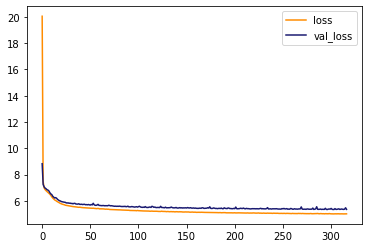

In [ ]:
loss_nn_df = pd.DataFrame(losses_nn.history)
loss_nn_df.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_nn_mse = model_nn.evaluate(X_test, y_test, batch_size=1)
y_pred_nn = model_nn.predict(X_test)

19797/19797 [==============================] - 36s 2ms/step - loss: 5.1837 - accuracy: 0.0016


In [ ]:
compa_k_mse.append(score_nn_mse[0])

In [ ]:
print('mse: %f'%score_nn_mse[0])

mse: 5.183654


In [ ]:
print(f"predicted response:\n{y_pred_nn[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[6.30372858e+09]
 [2.87130451e+09]
 [4.03692675e+09]
 [1.22057116e+09]
 [3.41993046e+09]
 [5.67166042e+09]
 [2.35731506e+09]
 [4.51562595e+09]
 [7.32437229e+09]
 [5.09371233e+09]]
actual:
67254    7.800000e+09
33028    1.790000e+09
12304    5.200000e+09
71296    1.305000e+09
48795    1.389000e+09
20723    4.800000e+09
4271     2.000000e+09
44233    3.330000e+09
22704    8.250000e+09
5264     6.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_nn)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  3
Percent correct prediction:  49.674193059554476


### MAE

In [ ]:
model_nn.compile(optimizer='adam',loss='mean_absolute_error',metrics=['accuracy'])
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_nn_2 = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
174/174 [==============================] - 3s 4ms/step - loss: 2.9410 - accuracy: 0.0015 - val_loss: 2.1410 - val_accuracy: 0.0015
Epoch 2/400
174/174 [==============================] - 0s 3ms/step - loss: 2.0004 - accuracy: 0.0016 - val_loss: 1.9594 - val_accuracy: 0.0015
Epoch 3/400
174/174 [==============================] - 0s 3ms/step - loss: 1.9150 - accuracy: 0.0016 - val_loss: 1.9051 - val_accuracy: 0.0015
Epoch 4/400
174/174 [==============================] - 0s 3ms/step - loss: 1.8736 - accuracy: 0.0016 - val_loss: 1.8748 - val_accuracy: 0.0015
Epoch 5/400
174/174 [==============================] - 0s 3ms/step - loss: 1.8480 - accuracy: 0.0015 - val_loss: 1.8533 - val_accuracy: 0.0015
Epoch 6/400
174/174 [==============================] - 0s 3ms/step - loss: 1.8255 - accuracy: 0.0015 - val_loss: 1.8337 - val_accuracy: 0.0015
Epoch 7/400
174/174 [==============================] - 0s 3ms/step - loss: 1.8096 - accuracy: 0.0015 - val_loss: 1.8207 - val_accuracy: 0.0015

#### Loss graph

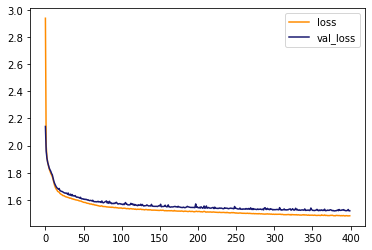

In [ ]:
loss_df_nn_2 = pd.DataFrame(losses_nn_2.history)
loss_df_nn_2.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_mae = model_nn.evaluate(X_test, y_test, batch_size=1)
y_pred_nn_2 = model_nn.predict(X_test)

19797/19797 [==============================] - 57s 3ms/step - loss: 1.5001 - accuracy: 0.0016


In [ ]:
compa_k_mae.append(score_mae[0])

In [ ]:
print('mae: %f'%score_mae[0])

mae: 1.500072


In [ ]:
print(f"predicted response:\n{y_pred_nn_2[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.75183821e+09]
 [3.71519470e+09]
 [4.28086185e+09]
 [1.50170982e+09]
 [1.95318103e+09]
 [5.82241154e+09]
 [2.96889567e+09]
 [3.93502665e+09]
 [5.98753071e+09]
 [6.01784754e+09]]
actual:
67254    7.800000e+09
33028    1.790000e+09
12304    5.200000e+09
71296    1.305000e+09
48795    1.389000e+09
20723    4.800000e+09
4271     2.000000e+09
44233    3.330000e+09
22704    8.250000e+09
5264     6.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_nn_2)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  1
Percent correct prediction:  52.84639086730313


### RMSE

In [ ]:
model_nn.compile(optimizer='adam',loss=root_mean_squared_error,metrics=['accuracy'])
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_nn_3 = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
174/174 [==============================] - 1s 4ms/step - loss: 2.2508 - accuracy: 0.0016 - val_loss: 2.3021 - val_accuracy: 0.0015
Epoch 2/400
174/174 [==============================] - 1s 3ms/step - loss: 2.2462 - accuracy: 0.0016 - val_loss: 2.2995 - val_accuracy: 0.0015
Epoch 3/400
174/174 [==============================] - 1s 3ms/step - loss: 2.2446 - accuracy: 0.0016 - val_loss: 2.2985 - val_accuracy: 0.0015
Epoch 4/400
174/174 [==============================] - 1s 3ms/step - loss: 2.2429 - accuracy: 0.0016 - val_loss: 2.2975 - val_accuracy: 0.0015
Epoch 5/400
174/174 [==============================] - 0s 3ms/step - loss: 2.2386 - accuracy: 0.0016 - val_loss: 2.2942 - val_accuracy: 0.0015
Epoch 6/400
174/174 [==============================] - 1s 3ms/step - loss: 2.2403 - accuracy: 0.0016 - val_loss: 2.2937 - val_accuracy: 0.0015
Epoch 7/400
174/174 [==============================] - 0s 3ms/step - loss: 2.2425 - accuracy: 0.0016 - val_loss: 2.2943 - val_accuracy: 0.0015

#### Loss graph

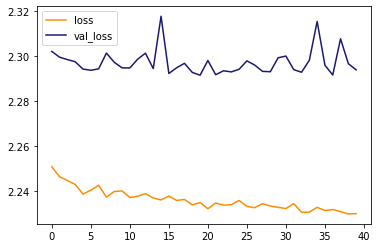

In [ ]:
loss_df_nn_3 = pd.DataFrame(losses_nn_3.history)
loss_df_nn_3.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_rmse = model_nn.evaluate(X_test, y_test, batch_size=1)
y_pred_nn_3 = model_nn.predict(X_test)

19797/19797 [==============================] - 61s 3ms/step - loss: 1.5172 - accuracy: 0.0016


In [ ]:
compa_k_rmse.append(score_rmse[0])

In [ ]:
print('rmse: %f'%score_rmse[0])

rmse: 1.517154


In [ ]:
print(f"predicted response:\n{y_pred_nn_3[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.76197672e+09]
 [3.66662121e+09]
 [3.74300003e+09]
 [1.24235356e+09]
 [2.67861319e+09]
 [5.96319056e+09]
 [2.50397921e+09]
 [3.90229273e+09]
 [6.26588154e+09]
 [6.26917219e+09]]
actual:
67254    7.800000e+09
33028    1.790000e+09
12304    5.200000e+09
71296    1.305000e+09
48795    1.389000e+09
20723    4.800000e+09
4271     2.000000e+09
44233    3.330000e+09
22704    8.250000e+09
5264     6.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_nn_3)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  3
Percent correct prediction:  51.179471637116734


### R2

In [ ]:
model_nn.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_nn_5 = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
174/174 [==============================] - 1s 4ms/step - loss: 5.0212 - accuracy: 0.0015 - val_loss: 5.2866 - val_accuracy: 0.0015
Epoch 2/400
174/174 [==============================] - 1s 3ms/step - loss: 5.0080 - accuracy: 0.0016 - val_loss: 5.3215 - val_accuracy: 0.0015
Epoch 3/400
174/174 [==============================] - 1s 3ms/step - loss: 5.0008 - accuracy: 0.0016 - val_loss: 5.3434 - val_accuracy: 0.0015
Epoch 4/400
174/174 [==============================] - 1s 3ms/step - loss: 5.0115 - accuracy: 0.0016 - val_loss: 5.2859 - val_accuracy: 0.0015
Epoch 5/400
174/174 [==============================] - 1s 3ms/step - loss: 5.0069 - accuracy: 0.0016 - val_loss: 5.3070 - val_accuracy: 0.0015
Epoch 6/400
174/174 [==============================] - 0s 3ms/step - loss: 5.0067 - accuracy: 0.0016 - val_loss: 5.3747 - val_accuracy: 0.0015
Epoch 7/400
174/174 [==============================] - 1s 3ms/step - loss: 5.0006 - accuracy: 0.0016 - val_loss: 5.2841 - val_accuracy: 0.0015

#### r2 values

In [ ]:
y_pred_nn_5 = model_nn.predict(X_test)
score_r2 = r2_score(y_test, y_pred_nn_5)

In [ ]:
compa_k_r2.append(score_r2)

In [ ]:
print('r2: %f'%score_r2)

r2: 0.623879


## LSTM

### Model structure

In [ ]:
K.clear_session()
model_1 = Sequential()

model_1.add(LSTM(128, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=True))
model_1.add(Dropout(0.3))

model_1.add(LSTM(64, activation='tanh', return_sequences=True))
model_1.add(Dropout(0.3))

model_1.add(LSTM(32, activation='relu', return_sequences=True))
model_1.add(Dropout(0.3))

model_1.add(LSTM(16, activation='relu'))
model_1.add(Dropout(0.3))

model_1.add(Dense(1))
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            71680     
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3

### MSE

In [ ]:
model_1.compile(loss='mean_squared_error', optimizer='adam')
# Training sẽ dừng khi "val_loss" không giảm (mode='min') sau 10 epochs(patience=10)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])
# losses = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=1)

Epoch 1/400
174/174 [==============================] - 36s 63ms/step - loss: 22.1984 - val_loss: 8.6347
Epoch 2/400
174/174 [==============================] - 5s 30ms/step - loss: 10.4078 - val_loss: 7.4033
Epoch 3/400
174/174 [==============================] - 5s 30ms/step - loss: 9.4257 - val_loss: 7.1710
Epoch 4/400
174/174 [==============================] - 5s 30ms/step - loss: 9.1423 - val_loss: 7.1389
Epoch 5/400
174/174 [==============================] - 5s 31ms/step - loss: 8.9287 - val_loss: 6.9016
Epoch 6/400
174/174 [==============================] - 5s 30ms/step - loss: 8.7269 - val_loss: 6.8552
Epoch 7/400
174/174 [==============================] - 5s 31ms/step - loss: 8.6496 - val_loss: 6.8074
Epoch 8/400
174/174 [==============================] - 5s 30ms/step - loss: 8.5247 - val_loss: 6.8444
Epoch 9/400
174/174 [==============================] - 5s 30ms/step - loss: 8.3773 - val_loss: 6.8299
Epoch 10/400
174/174 [==============================] - 5s 31ms/step - loss: 8.

#### Loss graph

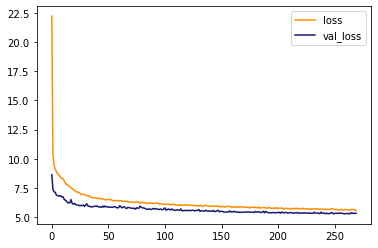

In [ ]:
loss_df = pd.DataFrame(losses.history)
loss_df.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_mse = model_1.evaluate(X_tst_t, y_test, batch_size=1)
y_pred_1 = model_1.predict(X_tst_t)

19797/19797 [==============================] - 66s 3ms/step - loss: 5.1465


In [ ]:
compa_k_mse.append(score_mse)

In [ ]:
print('mse: %f'%score_mse)

mse: 5.146486


In [ ]:
print(f"predicted response:\n{y_pred_1[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[6.47748375e+09]
 [3.58297014e+09]
 [4.31899881e+09]
 [2.54882693e+09]
 [3.19991922e+09]
 [5.99823380e+09]
 [3.05082631e+09]
 [4.33853054e+09]
 [6.88648987e+09]
 [5.26443815e+09]]
actual:
67254    7.800000e+09
33028    1.790000e+09
12304    5.200000e+09
71296    1.305000e+09
48795    1.389000e+09
20723    4.800000e+09
4271     2.000000e+09
44233    3.330000e+09
22704    8.250000e+09
5264     6.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_1)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  44.79971712885791


### MAE

In [ ]:
model_1.compile(loss='mean_absolute_error', optimizer='adam')
# Training sẽ dừng khi "val_loss" không giảm (mode='min') sau 10 epochs(patience=10)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_2 = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
174/174 [==============================] - 23s 85ms/step - loss: 3.5418 - val_loss: 2.0760
Epoch 2/400
174/174 [==============================] - 16s 90ms/step - loss: 2.3105 - val_loss: 1.9561
Epoch 3/400
174/174 [==============================] - 15s 85ms/step - loss: 2.1901 - val_loss: 1.8990
Epoch 4/400
174/174 [==============================] - 16s 89ms/step - loss: 2.1495 - val_loss: 1.8676
Epoch 5/400
174/174 [==============================] - 16s 89ms/step - loss: 2.1145 - val_loss: 1.8617
Epoch 6/400
174/174 [==============================] - 14s 81ms/step - loss: 2.0758 - val_loss: 1.8056
Epoch 7/400
174/174 [==============================] - 15s 88ms/step - loss: 2.0462 - val_loss: 1.8056
Epoch 8/400
174/174 [==============================] - 16s 93ms/step - loss: 2.0213 - val_loss: 1.7804
Epoch 9/400
174/174 [==============================] - 17s 97ms/step - loss: 2.0166 - val_loss: 1.7588
Epoch 10/400
174/174 [==============================] - 9s 52ms/step - lo

#### Loss graph

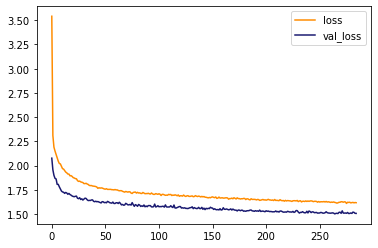

In [ ]:
loss_df_2 = pd.DataFrame(losses_2.history)
loss_df_2.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_mae = model_1.evaluate(X_tst_t, y_test, batch_size=1)
y_pred_lstm_2 = model_1.predict(X_tst_t)

19797/19797 [==============================] - 70s 4ms/step - loss: 1.4934


In [ ]:
compa_k_mae.append(score_mae)

In [ ]:
print('mae: %f'%score_mae)

mae: 1.493402


In [ ]:
print(f"predicted response:\n{y_pred_lstm_2[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[6.11541176e+09]
 [3.29741049e+09]
 [4.56056499e+09]
 [1.52764034e+09]
 [1.85518193e+09]
 [5.62667751e+09]
 [2.87924290e+09]
 [3.50198889e+09]
 [6.39624023e+09]
 [5.47213984e+09]]
actual:
67254    7.800000e+09
33028    1.790000e+09
12304    5.200000e+09
71296    1.305000e+09
48795    1.389000e+09
20723    4.800000e+09
4271     2.000000e+09
44233    3.330000e+09
22704    8.250000e+09
5264     6.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_lstm_2)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  53.321210284386524


### RMSE

In [ ]:
model_1.compile(loss=root_mean_squared_error, optimizer='adam')
# Training sẽ dừng khi "val_loss" không giảm (mode='min') sau 10 epochs(patience=10)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_3 = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
174/174 [==============================] - 14s 35ms/step - loss: 2.3816 - val_loss: 2.2887
Epoch 2/400
174/174 [==============================] - 6s 32ms/step - loss: 2.3744 - val_loss: 2.2828
Epoch 3/400
174/174 [==============================] - 6s 33ms/step - loss: 2.3843 - val_loss: 2.2778
Epoch 4/400
174/174 [==============================] - 6s 32ms/step - loss: 2.3841 - val_loss: 2.2783
Epoch 5/400
174/174 [==============================] - 6s 32ms/step - loss: 2.3804 - val_loss: 2.2674
Epoch 6/400
174/174 [==============================] - 6s 32ms/step - loss: 2.3801 - val_loss: 2.2746
Epoch 7/400
174/174 [==============================] - 6s 32ms/step - loss: 2.3820 - val_loss: 2.2777
Epoch 8/400
174/174 [==============================] - 5s 31ms/step - loss: 2.3693 - val_loss: 2.2807
Epoch 9/400
174/174 [==============================] - 5s 31ms/step - loss: 2.3807 - val_loss: 2.2770
Epoch 10/400
174/174 [==============================] - 5s 31ms/step - loss: 2.36

#### Loss graph

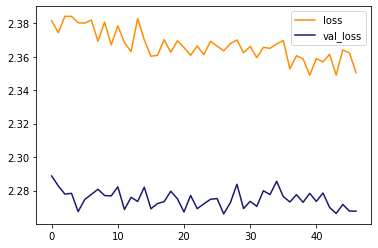

In [ ]:
loss_df_3 = pd.DataFrame(losses_3.history)
loss_df_3.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_rmse = model_1.evaluate(X_tst_t, y_test, batch_size=1)
y_pred_lstm_3 = model_1.predict(X_tst_t)

19797/19797 [==============================] - 71s 4ms/step - loss: 1.5182


In [ ]:
compa_k_rmse.append(score_rmse)

In [ ]:
print('rmse: %f'%score_rmse)

rmse: 1.518212


In [ ]:
print(f"predicted response:\n{y_pred_lstm_3[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[6.81785822e+09]
 [3.22021723e+09]
 [4.66333437e+09]
 [1.68142009e+09]
 [2.52565384e+09]
 [6.02213907e+09]
 [2.83750916e+09]
 [3.71054721e+09]
 [7.37552261e+09]
 [5.52058220e+09]]
actual:
67254    7.800000e+09
33028    1.790000e+09
12304    5.200000e+09
71296    1.305000e+09
48795    1.389000e+09
20723    4.800000e+09
4271     2.000000e+09
44233    3.330000e+09
22704    8.250000e+09
5264     6.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_lstm_3)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  50.002525635197244


### R2

In [ ]:
model_1.compile(loss='mean_squared_error', optimizer='adam')
# Training sẽ dừng khi "val_loss" không giảm (mode='min') sau 10 epochs(patience=10)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_5 = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
174/174 [==============================] - 14s 36ms/step - loss: 5.6199 - val_loss: 5.1940
Epoch 2/400
174/174 [==============================] - 5s 31ms/step - loss: 5.5405 - val_loss: 5.1650
Epoch 3/400
174/174 [==============================] - 6s 32ms/step - loss: 5.5905 - val_loss: 5.1778
Epoch 4/400
174/174 [==============================] - 6s 33ms/step - loss: 5.5712 - val_loss: 5.2601
Epoch 5/400
174/174 [==============================] - 5s 31ms/step - loss: 5.5897 - val_loss: 5.2040
Epoch 6/400
174/174 [==============================] - 8s 44ms/step - loss: 5.5185 - val_loss: 5.2424
Epoch 7/400
174/174 [==============================] - 6s 32ms/step - loss: 5.5494 - val_loss: 5.2428
Epoch 8/400
174/174 [==============================] - 6s 33ms/step - loss: 5.6042 - val_loss: 5.1437
Epoch 9/400
174/174 [==============================] - 5s 31ms/step - loss: 5.5530 - val_loss: 5.2488
Epoch 10/400
174/174 [==============================] - 6s 32ms/step - loss: 5.56

#### r2 values

In [ ]:
y_pred_lstm_5 = model_1.predict(X_tst_t)
score_r2 = r2_score(y_test, y_pred_lstm_5)

In [ ]:
compa_k_r2.append(score_r2)

In [ ]:
print('r2: %f'%score_r2)

r2: 0.631516


## Linear regression

In [ ]:
model_2 = LinearRegression()

### K-Fold

In [ ]:
scores_2_mse = mean(absolute(cross_val_score(model_2, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_2_mae = mean(absolute(cross_val_score(model_2, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_2_rmse = sqrt(mean(absolute(scores_2_mse)))
scores_2_r2 = mean(absolute(cross_val_score(model_2, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_2.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred_2 = model_2.predict(X_test)
# Sai số huấn luyện của mô hình trên tập train
print(model_2.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_2.coef_)
print(model_2.intercept_)

0.4828249777025295
[-4.68957703  1.87653524  7.26309929  0.17207429 -2.226531   -2.46665112
  2.75619475  1.84672596  4.35494357 -1.69426477  0.14858812]
1.6917379850203589


In [ ]:
print(f"predicted response:\n{y_pred_2[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.71593038e+09 3.01776409e+09 4.27223146e+09 5.17990924e+09
 3.87821369e+09 5.41367374e+09 2.66030794e+09 4.93497214e+09
 9.18849966e+09 5.34673460e+09]
actual:
67254    7.800000e+09
33028    1.790000e+09
12304    5.200000e+09
71296    1.305000e+09
48795    1.389000e+09
20723    4.800000e+09
4271     2.000000e+09
44233    3.330000e+09
22704    8.250000e+09
5264     6.500000e+09
Name: price, dtype: float64


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_2))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_2))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_2)))
compa_n_r2.append(r2_score(y_test, y_pred_2))
compa_k_mse.append(scores_2_mse)
compa_k_mae.append(scores_2_mae)
compa_k_rmse.append(scores_2_rmse)
compa_k_r2.append(scores_2_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_2)}")
print(f"mse (K-fold):\n{scores_2_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_2)}")
print(f"mae (K-fold):\n{scores_2_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_2))}")
print(f"rmse (K-fold):\n{scores_2_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_2)}")
print(f"r2 (K-fold):\n{scores_2_r2}")

mse:
7.113620772212428
mse (K-fold):
7.088315285993592
mae:
1.9273172948634343
mae (K-fold):
1.9286116378292075
rmse:
2.6671371866127225
rmse (K-fold):
2.6623890185308365
r2:
0.47700478986299555
r2 (K-fold):
0.481330440304352


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_2)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  139
Percent correct prediction:  37.429913623276256


## Ridge regression

In [ ]:
model_3 = Ridge(alpha = 0.3,  tol = 0.003, solver ='auto', random_state = 42)

### K-Fold

In [ ]:
scores_3_mse = mean(absolute(cross_val_score(model_3, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_3_mae = mean(absolute(cross_val_score(model_3, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_3_rmse = sqrt(mean(absolute(scores_3_mse)))
scores_3_r2 = mean(absolute(cross_val_score(model_3, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
# training model with alpha = 0.5

model_3.fit(X_train, y_train)

y_pred_3 = model_3.predict(X_test)

# Sai số huấn luyện của mô hình trên tập train
print(model_3.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_3.coef_)
print(model_3.intercept_)

0.4828234073125406
[-3.88377918  1.87558257  7.25842563  0.17388518 -2.2259155  -2.46632077
  2.7556802   1.84837195  4.35337205 -1.69444396  0.14871563]
1.6928391184662992


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_3))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_3))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_3)))
compa_n_r2.append(r2_score(y_test, y_pred_3))
compa_k_mse.append(scores_3_mse)
compa_k_mae.append(scores_3_mae)
compa_k_rmse.append(scores_3_rmse)
compa_k_r2.append(scores_3_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_3)}")
print(f"mse (K-fold):\n{scores_3_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_3)}")
print(f"mae (K-fold):\n{scores_3_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_3))}")
print(f"rmse (K-fold):\n{scores_3_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_3)}")
print(f"r2 (K-fold):\n{scores_3_r2}")

mse:
7.11357205728049
mse (K-fold):
7.088177173349865
mae:
1.9272794570433989
mae (K-fold):
1.9285600961066414
rmse:
2.667128054158722
rmse (K-fold):
2.662363080676613
r2:
0.4770083713971933
r2 (K-fold):
0.4813402532655101


In [ ]:
print(f"predicted response:\n{y_pred_3[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.71537647e+09 3.01803831e+09 4.27258858e+09 5.18009472e+09
 3.87865772e+09 5.41301398e+09 2.66076636e+09 4.93480970e+09
 9.18850746e+09 5.34555824e+09]
actual:
67254    7.800000e+09
33028    1.790000e+09
12304    5.200000e+09
71296    1.305000e+09
48795    1.389000e+09
20723    4.800000e+09
4271     2.000000e+09
44233    3.330000e+09
22704    8.250000e+09
5264     6.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_3)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  139
Percent correct prediction:  37.45011870485427


## Lasso regression

In [ ]:
model_4 = Lasso(alpha=0.3)

### K-Fold

In [ ]:
scores_4_mse = mean(absolute(cross_val_score(model_4, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_4_mae = mean(absolute(cross_val_score(model_4, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_4_rmse = sqrt(mean(absolute(scores_4_mse)))
scores_4_r2 = mean(absolute(cross_val_score(model_4, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_4.fit(X_train, y_train)

y_pred_4 = model_4.predict(X_test)

# Sai số huấn luyện của mô hình trên tập train
print(model_4.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_4.coef_)
print(model_4.intercept_)

0.1157771513992707
[ 0.          0.          0.          0.         -0.         -0.
  0.80614082  0.          1.47798459 -0.          0.        ]
4.682459817394747


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_4))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_4))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_4)))
compa_n_r2.append(r2_score(y_test, y_pred_4))
compa_k_mse.append(scores_4_mse)
compa_k_mae.append(scores_4_mae)
compa_k_rmse.append(scores_4_rmse)
compa_k_r2.append(scores_4_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_4)}")
print(f"mse (K-fold):\n{scores_4_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_4)}")
print(f"mae (K-fold):\n{scores_4_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_4))}")
print(f"rmse (K-fold):\n{scores_4_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_4)}")
print(f"r2 (K-fold):\n{scores_4_r2}")

mse:
12.053435973776127
mse (K-fold):
12.08353619192896
mae:
2.6175090438766513
mae (K-fold):
2.628983916276441
rmse:
3.4718058663721574
rmse (K-fold):
3.476138114622168
r2:
0.11382831868089827
r2 (K-fold):
0.11594322894220466


In [ ]:
print(f"predicted response:\n{y_pred_4[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[5.95168911e+09 4.79762279e+09 5.21269681e+09 4.79762279e+09
 4.79762279e+09 5.22870163e+09 4.79762279e+09 5.33586220e+09
 5.83652614e+09 5.10553625e+09]
actual:
67254    7.800000e+09
33028    1.790000e+09
12304    5.200000e+09
71296    1.305000e+09
48795    1.389000e+09
20723    4.800000e+09
4271     2.000000e+09
44233    3.330000e+09
22704    8.250000e+09
5264     6.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_4)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  25.59478708895287


## Polynomial regression

In [ ]:
model_5 = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])

### K-Fold

In [ ]:
scores_5_mse = mean(absolute(cross_val_score(model_5, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_5_mae = mean(absolute(cross_val_score(model_5, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_5_rmse = sqrt(mean(absolute(scores_5_mse)))
scores_5_r2 = mean(absolute(cross_val_score(model_5, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_5.fit(X_train, y_train)
y_pred_5 = model_5.predict(X_test)
# Sai số huấn luyện của mô hình trên tập train
print(model_5.score(X_train, y_train))

0.608905296030875


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_5))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_5))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_5)))
compa_n_r2.append(r2_score(y_test, y_pred_5))
compa_k_mse.append(scores_5_mse)
compa_k_mae.append(scores_5_mae)
compa_k_rmse.append(scores_5_rmse)
compa_k_r2.append(scores_5_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_5)}")
print(f"mse (K-fold):\n{scores_5_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_5)}")
print(f"mae (K-fold):\n{scores_5_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_5))}")
print(f"rmse (K-fold):\n{scores_5_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_5)}")
print(f"r2 (K-fold):\n{scores_5_r2}")

mse:
167.72602342688336
mse (K-fold):
2296571.2979258867
mae:
1.703356548246263
mae (K-fold):
9.478917949294296
rmse:
12.950908208572994
rmse (K-fold):
1515.4442576109116
r2:
-11.331259941525527
r2 (K-fold):
161908.35729446117


In [ ]:
print(f"predicted response:\n{y_pred_5[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[5.92988178e+09 3.81332032e+09 3.47363938e+09 1.78582787e+09
 3.03545182e+09 5.78283169e+09 2.57184848e+09 4.45707179e+09
 9.75574560e+09 5.92510461e+09]
actual:
67254    7.800000e+09
33028    1.790000e+09
12304    5.200000e+09
71296    1.305000e+09
48795    1.389000e+09
20723    4.800000e+09
4271     2.000000e+09
44233    3.330000e+09
22704    8.250000e+09
5264     6.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_5)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  17
Percent correct prediction:  47.36071121887155


## Bayesian linear regression

In [ ]:
model_6 = BayesianRidge()

### K-Fold

In [ ]:
scores_6_mse = mean(absolute(cross_val_score(model_6, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_6_mae = mean(absolute(cross_val_score(model_6, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_6_rmse = sqrt(mean(absolute(scores_6_mse)))
scores_6_r2 = mean(absolute(cross_val_score(model_6, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_6.fit(X_train, y_train)
y_pred_6 = model_6.predict(X_test)
# Sai số huấn luyện của mô hình trên tập train
print(model_6.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_6.coef_)
print(model_6.intercept_)

0.4828194854969713
[-3.18636542  1.87452402  7.25300157  0.1762461  -2.22518372 -2.46592979
  2.75483808  1.85045334  4.35144552 -1.69465926  0.14883509]
1.6941754172390486


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_6))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_6))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_6)))
compa_n_r2.append(r2_score(y_test, y_pred_6))
compa_k_mse.append(scores_6_mse)
compa_k_mae.append(scores_6_mae)
compa_k_rmse.append(scores_6_rmse)
compa_k_r2.append(scores_6_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_6)}")
print(f"mse (K-fold):\n{scores_6_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_6)}")
print(f"mae (K-fold):\n{scores_6_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_6))}")
print(f"rmse (K-fold):\n{scores_6_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_6)}")
print(f"r2 (K-fold):\n{scores_6_r2}")

mse:
7.113521134723739
mse (K-fold):
7.088172675920054
mae:
1.9272358016317617
mae (K-fold):
1.928529339301479
rmse:
2.667118507813955
rmse (K-fold):
2.662362236045286
r2:
0.4770121152365293
r2 (K-fold):
0.48134065992225683


In [ ]:
print(f"predicted response:\n{y_pred_6[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.71469090e+09 3.01838927e+09 4.27301639e+09 5.18036572e+09
 3.87921644e+09 5.41224832e+09 2.66134188e+09 4.93458711e+09
 9.18857227e+09 5.34414115e+09]
actual:
67254    7.800000e+09
33028    1.790000e+09
12304    5.200000e+09
71296    1.305000e+09
48795    1.389000e+09
20723    4.800000e+09
4271     2.000000e+09
44233    3.330000e+09
22704    8.250000e+09
5264     6.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_6)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  139
Percent correct prediction:  37.44001616406526


# COMPARISION

## Normal

### MSE

In [ ]:
print(compa_n_mse)

[7.113620772212428, 7.11357205728049, 12.053435973776127, 167.72602342688336, 7.113521134723739]


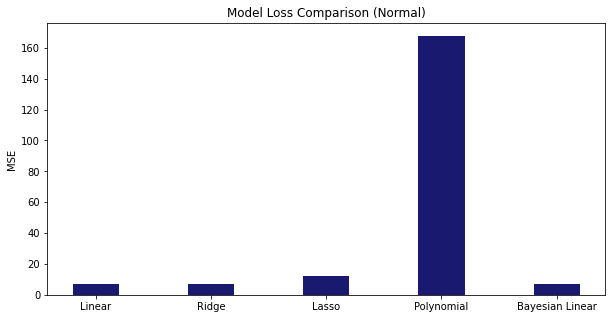

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels, compa_n_mse, width = 0.4, color = 'midnightblue')

plt.ylabel('MSE')
plt.title('Model Loss Comparison (Normal)')
plt.show()

### MAE

In [ ]:
print(compa_n_mae)

[1.9273172948634343, 1.9272794570433989, 2.6175090438766513, 1.703356548246263, 1.9272358016317617]


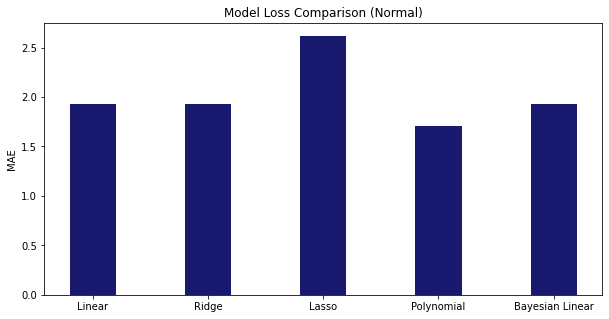

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels, compa_n_mae, width = 0.4, color = 'midnightblue')

plt.ylabel('MAE')
plt.title('Model Loss Comparison (Normal)')
plt.show()

### RMSE

In [ ]:
print(compa_n_rmse)

[2.6671371866127225, 2.667128054158722, 3.4718058663721574, 12.950908208572994, 2.667118507813955]


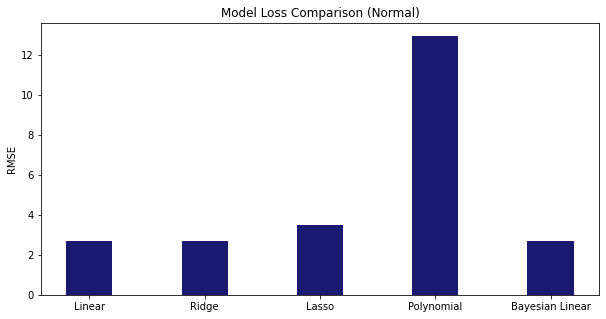

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels, compa_n_rmse, width = 0.4, color = 'midnightblue')

plt.ylabel('RMSE')
plt.title('Model Loss Comparison (Normal)')
plt.show()

### R2

In [ ]:
print(compa_n_r2)

[0.47700478986299555, 0.4770083713971933, 0.11382831868089827, -11.331259941525527, 0.4770121152365293]


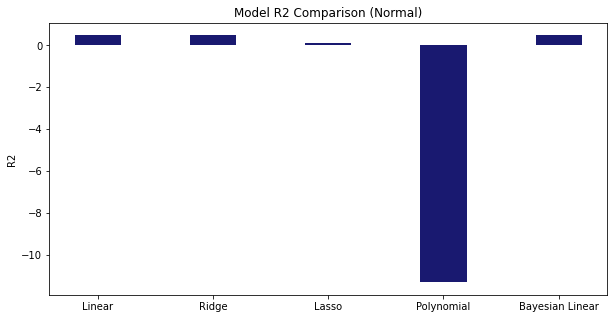

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels, compa_n_r2, width = 0.4, color = 'midnightblue')

plt.ylabel('R2')
plt.title('Model R2 Comparison (Normal)')
plt.show()

## K-Fold

### MSE

In [ ]:
print(compa_k_mse)

[5.183654308319092, 5.146486, 7.088315285993592, 7.088177173349865, 12.08353619192896, 2296571.2979258867, 7.088172675920054]


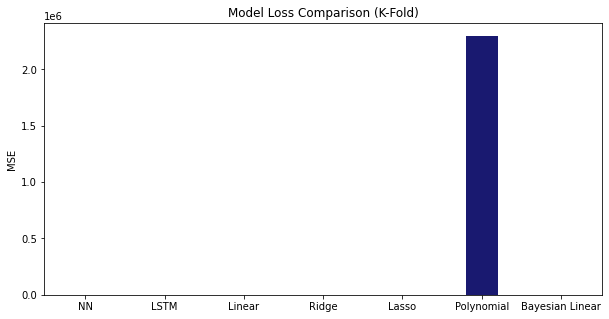

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels_kfold, compa_k_mse, width = 0.4, color = 'midnightblue')

plt.ylabel('MSE')
plt.title('Model Loss Comparison (K-Fold)')
plt.show()

### MAE

In [ ]:
print(compa_k_mae)

[1.5000722408294678, 1.493402123451233, 1.9286116378292075, 1.9285600961066414, 2.628983916276441, 9.478917949294296, 1.928529339301479]


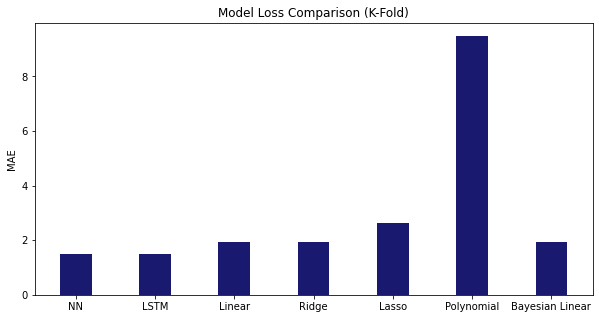

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels_kfold, compa_k_mae, width = 0.4, color = 'midnightblue')

plt.ylabel('MAE')
plt.title('Model Loss Comparison (K-Fold)')
plt.show()

### RMSE

In [ ]:
print(compa_k_rmse)

[1.5171540975570679, 1.5182119607925415, 2.6623890185308365, 2.662363080676613, 3.476138114622168, 1515.4442576109116, 2.662362236045286]


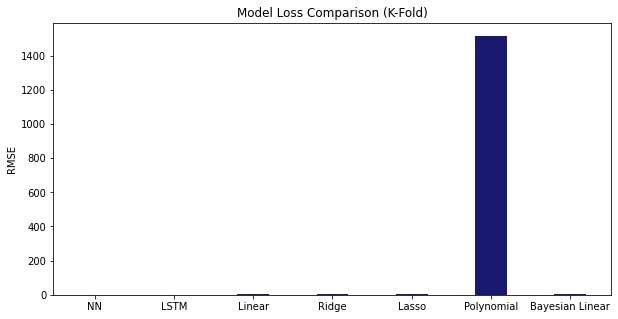

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels_kfold, compa_k_rmse, width = 0.4, color = 'midnightblue')

plt.ylabel('RMSE')
plt.title('Model Loss Comparison (K-Fold)')
plt.show()

### R2

In [ ]:
print(compa_k_r2)

[0.6238794705677004, 0.6315157422494198, 0.481330440304352, 0.4813402532655101, 0.11594322894220466, 161908.35729446117, 0.48134065992225683]


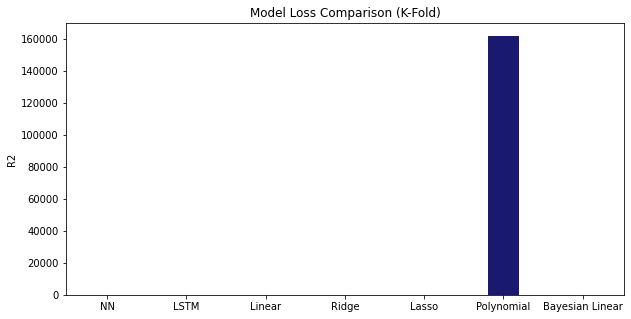

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels_kfold, compa_k_r2, width = 0.4, color = 'midnightblue')

plt.ylabel('R2')
plt.title('Model Loss Comparison (K-Fold)')
plt.show()